In [16]:
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

In [7]:
tokenizer = tiktoken.get_encoding("gpt2")

In [8]:
with open("../datasets/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of characters:", len(raw_text))

Total number of characters: 20467


# Implement a data loader to create input-target pairs using a sliding window approach

In [9]:
# Byte-pair encode
enc_text = tokenizer.encode(raw_text)

# Count of the vocabulary for this dataset
print(len(enc_text))

5142


In [10]:
enc_sample = enc_text[50:]

In [11]:
# Context size determines the number of tokens in the input (model will consider 4 tokens at a time)
context_size = 4

In [12]:
# Input x is the first 4 tokens [1,2,3,4] and y is the next 4 tokens [2,3,4,5] - this forms the sliding window of input-output pairs
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y: {y}")

x: [290, 4920, 2241, 287]
y: [4920, 2241, 287, 257]


In [13]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    # Context will be input, desired will be predicted (target) token
    print(context, "----->", desired)

[290] -----> 4920
[290, 4920] -----> 2241
[290, 4920, 2241] -----> 287
[290, 4920, 2241, 287] -----> 257


In [14]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    # Context will be input, desired will be predicted (target) token
    print(tokenizer.decode(context), "----->", tokenizer.decode([desired]))

 and ----->  established
 and established ----->  himself
 and established himself ----->  in
 and established himself in ----->  a


# Data Loader
- iterate over the dataset and return PyTorch tensors
- one tensor for input text, one for output
- input tensor is shifted by one to create the next word prediction
- each row represents one input context

1. Tokenize the text corpus
2. Use a sliding window to chunk the text into overlapping sequences of max_length
3. Return the total number of rows in the dataset
4. Return a single row from the dataset

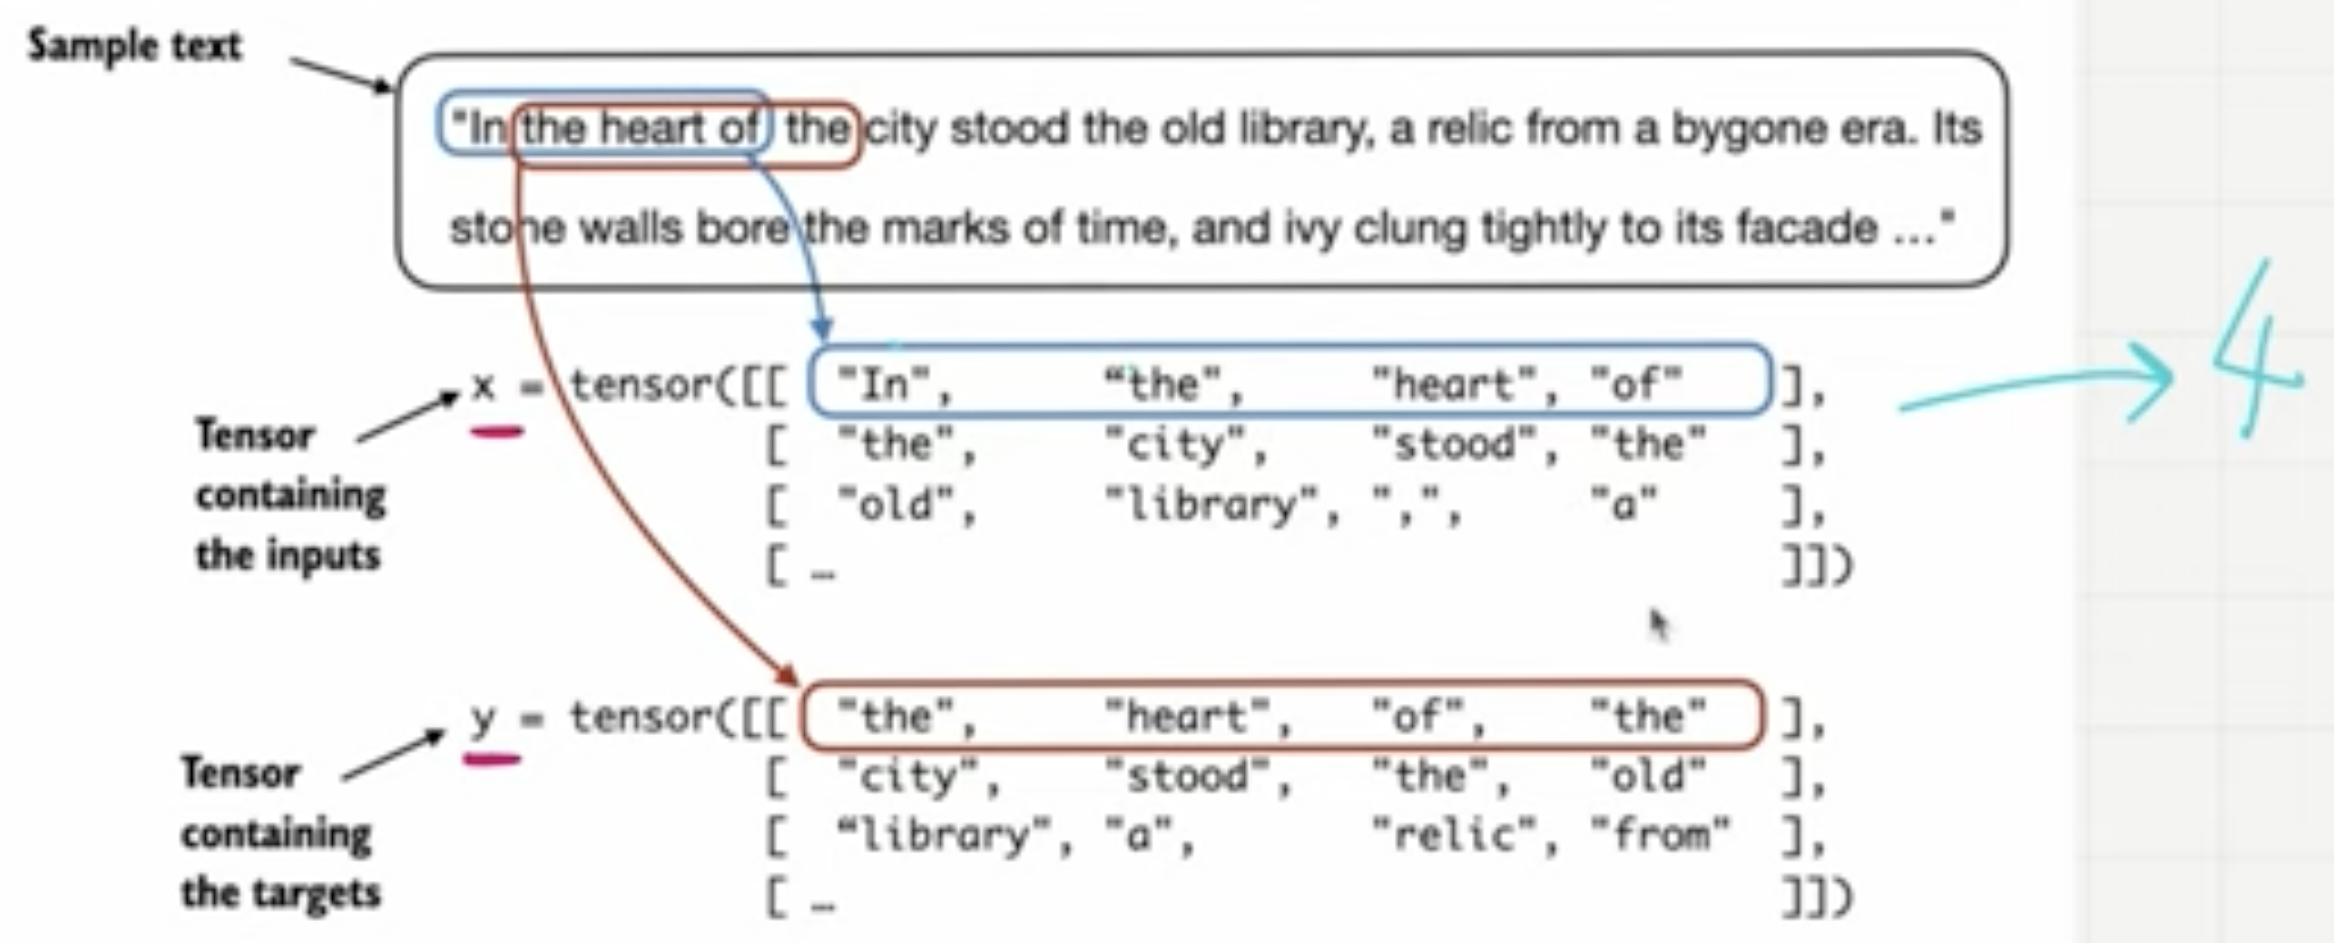

In [ ]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        """
        Define how the individual rows are fetched from the dataset and tokenized
        """
        self.input_ids = []
        self.target_ids = []

        # Tokenize the text
        token_ids = tokenizer.encode(txt, allowed_special = {"<|endoftext|>"})

        # Sliding window to chunk the text into overlapping sequnces of max_length
        # The stride will build the context by specifying the number of tensors to consider
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        """
        Returns the number of samples in the dataset
        """
        return len(self.input_ids)

    def __getitem__(self, idx):
        """
        Loads and returns a sample input and target from the dataset at the given index (idx)
        """
        return self.input_ids[idx], self.target_ids[idx]

# Use the Dataset class above to load the inputs in batches using the DataLoader class



In [45]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128,
                        shuffle=True, drop_last=True, num_workers=0):
    """
    Batch loading definition

    - batch_size to determine number of parallel processing units done at once until the model updates parameters
        * Small batch sizes require less memory during training but lead to more noisy model updates, larger will take longer
        * batch_size is a tradeoff and a hyperparameter to experiment with in training
    - max_length is the context length as the number of token IDs in each tensor
    - stride to define how many positions to shift the input field for each input chunk
    - drop_last = True drops the last batch if is is shorter than batch_size to prevent loss spikes during training
    - num_workers is number of CPU threads to use for parallel processing

    1. Initialize the tokenizer
    2. Create the dataset
    3. Create the dataloader with the defined parameters
    """

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create the dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [28]:
# Test the data loader with a batch size of 1 and a context size of 4
with open("../datasets/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [41]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [42]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


In [43]:
third_batch = next(data_iter)
print(third_batch)

[tensor([[2885, 1464, 1807, 3619]]), tensor([[1464, 1807, 3619,  402]])]


In [ ]:
# Experiment with different batch_size and stride
# Stride of 4 will mean we don't skip a single word and also avoid overlap between batches which could lead to overfitting
second_dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

second_data_iter = iter(second_dataloader)
inputs, targets = next(second_data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])
